##### Jahnavi Pakanati-9013742
##### Reinforcement Learning-CSCN8020
##### Assignment-2

##### Importing the required libraries 

In [1]:
import importlib, assignment2_utils  # this imports the OLD cached version
importlib.reload(assignment2_utils)  # this forces Python to re-read the file you just saved
from assignment2_utils import describe_env


##### Checking the values 

In [2]:
import gymnasium as gym
from assignment2_utils import describe_env

env = gym.make("Taxi-v3")
_ = describe_env(env)


Observation space: Discrete(500)
Number of states: 500
Action space: Discrete(6)
Number of actions: 6
Reward range: (-10, 20)
Action descriptions: {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pick up passenger', 5: 'Drop off passenger'}


### Step 2 — Write a minimal Q-Learning agent in tabular form

##### This code implements a Q-learning agent that learns optimal actions through trial and error in a Gym environment.  
##### It updates a Q-table based on rewards using the Bellman equation and balances exploration (random actions) with exploitation (best actions).  
##### Over many episodes, it tracks total rewards, steps, and performance improvement using a moving average.


In [3]:
import numpy as np
import gymnasium as gym
from typing import Tuple
from dataclasses import dataclass

@dataclass
class QConfig:
    alpha: float = 0.1        # learning rate
    gamma: float = 0.9        # discount factor
    epsilon: float = 0.1      # exploration rate
    episodes: int = 5000
    max_steps: int = 200      # per episode cap

class QAgent:
    def __init__(self, n_states: int, n_actions: int, cfg: QConfig):
        self.n_states = n_states
        self.n_actions = n_actions
        self.cfg = cfg
        self.Q = np.zeros((n_states, n_actions), dtype=np.float32)

    def select_action(self, state: int) -> int:
        if np.random.rand() < self.cfg.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, s: int, a: int, r: float, s2: int):
        best_next = np.max(self.Q[s2])
        td_target = r + self.cfg.gamma * best_next
        td_error = td_target - self.Q[s, a]
        self.Q[s, a] += self.cfg.alpha * td_error

def run_training(env: gym.Env, agent: QAgent) -> Tuple[list, list, list]:
    episode_returns = []
    episode_steps = []
    moving_avg = []

    for ep in range(agent.cfg.episodes):
        state, info = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        for t in range(agent.cfg.max_steps):
            a = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            agent.update(state, a, reward, next_state)

            state = next_state
            total_reward += reward
            steps += 1
            if done:
                break

        episode_returns.append(total_reward)
        episode_steps.append(steps)
        # simple moving average (window 100)
        window = 100
        avg = np.mean(episode_returns[-window:]) if len(episode_returns) >= window else np.mean(episode_returns)
        moving_avg.append(avg)

    return episode_returns, episode_steps, moving_avg
print(" QAgent + run_training are defined and ready.")

 QAgent + run_training are defined and ready.


##### This code trains the Q-learning agent on the Taxi-v3 environment for 10 quick episodes.  
##### It initializes the environment, runs training to update the Q-table, and then plots the episode rewards to visualize the agent’s performance.  
##### The print statements display states, actions, and learning progress during this short test run.


States: 500 Actions: 6
Episode returns: [-298.0, -235.0, -271.0, -244.0, -262.0, -280.0, -262.0, -244.0, -253.0, -307.0]
Episode steps:   [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Final moving avg: -265.6


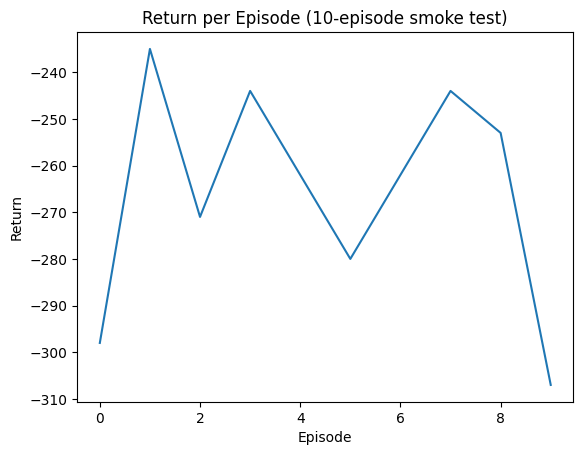

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Make env
env = gym.make("Taxi-v3")

# Sizes
n_states = env.observation_space.n
n_actions = env.action_space.n
print("States:", n_states, "Actions:", n_actions)

# Quick 10-episode training so you see output immediately
base_cfg = QConfig(alpha=0.1, gamma=0.9, epsilon=0.1, episodes=10, max_steps=100)
agent = QAgent(n_states, n_actions, base_cfg)
returns, steps, ma = run_training(env, agent)

print("Episode returns:", returns)
print("Episode steps:  ", steps)
print("Final moving avg:", ma[-1])

# Quick plots (these should pop below the cell)
plt.figure()
plt.plot(returns)
plt.title("Return per Episode (10-episode smoke test)")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.show()
